<a href="https://colab.research.google.com/github/dubidub/THE-REPRESENTATION-AND-MEASUREMENTS-OF-URBAN-TRANSPORTATION-NETWORKS/blob/main/4_2_Analysis_and_Conclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas import json_normalize
from json import dump
import matplotlib.pyplot as plt
import ast
from matplotlib import ticker as tkr
from google.colab import files
# use shapefile library to read SHP file
!pip install pyshp
import shapefile
from shapely.geometry import Polygon
# coordinate system change: credit to https://github.com/yychen/twd97
!pip install twd97
from twd97 import towgs84 # convert the coordinate system from TWD97 to WGS84
from matplotlib import ticker as tkr
from sklearn.cluster import KMeans

# GEO DATA ACQUISITION

## Villages SHP Files (TWD97_121 zone)

In [ ]:
# Download the original SHP file (TWD97_121 zone) from the MOI
# source: https://data.gov.tw/dataset/7440
!wget 'https://data.moi.gov.tw/MoiOD/System/DownloadFile.aspx?DATA=06CBF77D-252B-48DA-9E02-F7DE46B735D4'
!unzip 'DownloadFile.aspx?DATA=06CBF77D-252B-48DA-9E02-F7DE46B735D4'

tp_sf = shapefile.Reader('VILLAGE_MOI_121_1100316', encoding="UTF8")
len(tp_sf)

7670

In [ ]:
# Read SHP to GeoJSON (WGS84)
shapes = tp_sf.shapes()
tp_data = {}
tp_data['features'] = []
for i in range(len(shapes)):
  properties = tp_sf.record(i).as_dict()
  if properties['COUNTYNAME'] == '臺北市': # list villages in Taipei City
    geometry = {}
    geometry['type'] = 'Polygon' 
    geometry['coordinates'] = []
    geometry['coordinates'].append([])
    for j in shapes[i].points:
      coord = list(towgs84(j[0], j[1])) # convert the coordinate system to WGS84
      coord[0], coord[1] = coord[1], coord[0]
      geometry['coordinates'][0].append(list(coord))
    item = {}
    item['geometry'] = geometry
    item['properties'] = properties
    item['type'] = "Feature"
    tp_data['features'].append(item)
tp_data['type'] = "FeatureCollection"

len(tp_data['features'])

456

In [ ]:
# convert GeoJSON to dataframe
tp_df = json_normalize(tp_data['features'])
tp_df.rename(columns = {'properties.VILLCODE': 'vill_code',
                        'properties.TOWNCODE': 'town_code',
                        'geometry.coordinates': 'wgs84',                      
                        'properties.COUNTYNAME': 'county',
                        'properties.TOWNNAME': 'town', 
                        'properties.VILLNAME': 'village',
                        'properties.VILLENG': 'village_eng'}, inplace=True)
tp_df = tp_df[['vill_code', 'town_code', 'wgs84', 'county', 'town', 'village', 'village_eng']]
tp_df.sort_values(by='vill_code', inplace=True)
tp_df.reset_index(drop=True, inplace=True)
tp_df

,vill_code,town_code,wgs84,county,town,village,village_eng
0,63000010002,63000010,"[[[121.5714340320004, 25.0742919721458], [121....",臺北市,松山區,莊敬里,Zhuangjing Vil.
1,63000010003,63000010,"[[[121.56153938900036, 25.058712184142802], [1...",臺北市,松山區,東榮里,Dongrong Vil.
2,63000010004,63000010,"[[[121.5633827720004, 25.058849939142792], [12...",臺北市,松山區,三民里,Sanmin Vil.
3,63000010005,63000010,"[[[121.5655855850003, 25.060436191143076], [12...",臺北市,松山區,新益里,Xinyi Vil.
4,63000010006,63000010,"[[[121.5655855850003, 25.060436191143076], [12...",臺北市,松山區,富錦里,Fujin Vil.
...,...,...,...,...,...,...,...
451,63000120038,63000120,"[[[121.47442827300037, 25.122642139155197], [1...",臺北市,北投區,關渡里,Guandu Vil.
452,63000120039,63000120,"[[[121.53242393400038, 25.16209505816272], [12...",臺北市,北投區,泉源里,Quanyuan Vil.
453,63000120040,63000120,"[[[121.55391401000045, 25.156192149161587], [1...",臺北市,北投區,湖山里,Hushan Vil.
454,63000120041,63000120,"[[[121.50287602597734, 25.173346592027723], [1...",臺北市,北投區,大屯里,Datun Vil.


## Taipei Landuse SHP (TWD97)

In [ ]:
# dowanload SHP file (TM2) from Taipei City Gov
# source: https://data.taipei/#/dataset/detail?id=a4da6624-d896-4d54-9651-3d4bbd839942
# above link has been removed. use the back-up file
!7z e '/content/drive/My Drive/Colab Notebooks/Taipei Transportation/村里界、土地使用/臺北市土地使用分區圖(1090911).7z'
# read SHP file
landuse_sf = shapefile.Reader('p109093-面', encoding="BIG5")
len(landuse_sf)

15536

In [ ]:
# convert SHP to GeoJSON (WGS84)
shapes = landuse_sf.shapes()
landuse_data = {}
landuse_data['features'] = []

for i in range(len(shapes)):
  geometry = {}
  geometry['type'] = 'Polygon' 
  geometry['coordinates'] = []
  geometry['coordinates'].append([])
  for j in shapes[i].points:
    coord = list(towgs84(j[0], j[1])) # convert the coordinate system
    coord[0], coord[1] = coord[1], coord[0]
    geometry['coordinates'][0].append(list(coord))
  properties = landuse_sf.record(i).as_dict()
  item = {}
  item['geometry'] = geometry
  item['properties'] = properties
  item['type'] = "Feature"
  landuse_data['features'].append(item)
landuse_data['type'] = "FeatureCollection"

len(landuse_data['features'])

15536

## Floor Area Ratio File

In [ ]:
# read the amended file with FAR
landuse_output = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Taipei Transportation/tp_landuse_far_20210304.xlsx', index_col=0)
landuse_output

# merge with landuse dataframe 
for i in range(len(landuse_data['features'])):
  landuse_data['features'][i]['properties']['容積率'] = landuse_output['容積率'][i]
  landuse_data['features'][i]['properties']['分區顏色'] = landuse_output['分區顏色'][i]

landuse_df = json_normalize(landuse_data['features'])
landuse_df.rename(columns = {'geometry.coordinates': 'wgs84', 
                             'properties.編號': 'number', 
                             'properties.分區顏色': 'color',
                             'properties.分區代碼': 'zone_code', 
                             'properties.分區簡稱': 'zone_short',
                             'properties.使用分區': 'zone',
                             'properties.容積率': 'far',}, inplace=True)
landuse_df = landuse_df[['wgs84', 'number', 'color', 'zone_code', 'zone_short', 'zone', 'far']]
landuse_df

,wgs84,number,color,zone_code,zone_short,zone,far
0,"[[[121.51196786716957, 25.073646015987084], [1...",1,0.4,R3,住3,第三種住宅區,225.0
1,"[[[121.51179973637552, 25.073036849540628], [1...",2,0.4,R3,住3,第三種住宅區,225.0
2,"[[[121.51179821895477, 25.072671759954865], [1...",3,0.4,R3,住3,第三種住宅區,225.0
3,"[[[121.51149685538523, 25.072212376497188], [1...",4,0.4,R3,住3,第三種住宅區,225.0
4,"[[[121.51273424099841, 25.07262140340815], [12...",5,0.4,R3,住3,第三種住宅區,225.0
...,...,...,...,...,...,...,...
15531,"[[[121.55636647060581, 25.00930213210222], [12...",15532,34.0,PDB,墓,公墓用地,0.0
15532,"[[[121.55539456798925, 25.01354809349075], [12...",15533,11.0,PTA3,高速公路,高速公路用地,0.0
15533,"[[[121.44655254340645, 25.219462492137303], [1...",15534,0.0,細部計畫範圍,細部計畫範圍,,0.0
15534,"[[[121.44655254340645, 25.219462492137303], [1...",15535,0.0,規劃範圍,規劃範圍,,0.0


In [ ]:
# find lands which are not polygons
for i in range(len(landuse_df)):
  if len(landuse_df.iloc[i]['wgs84'][0]) <= 1:
    print(i)

9677
9678


In [ ]:
# remove lands which are not polygons 
landuse_df.drop([9677, 9678, 15533, 15534, 15535], inplace=True)
landuse_df.reset_index(drop=True, inplace=True)
landuse_df

,wgs84,number,color,zone_code,zone_short,zone,far
0,"[[[121.51196786716957, 25.073646015987084], [1...",1,0.4,R3,住3,第三種住宅區,225.0
1,"[[[121.51179973637552, 25.073036849540628], [1...",2,0.4,R3,住3,第三種住宅區,225.0
2,"[[[121.51179821895477, 25.072671759954865], [1...",3,0.4,R3,住3,第三種住宅區,225.0
3,"[[[121.51149685538523, 25.072212376497188], [1...",4,0.4,R3,住3,第三種住宅區,225.0
4,"[[[121.51273424099841, 25.07262140340815], [12...",5,0.4,R3,住3,第三種住宅區,225.0
...,...,...,...,...,...,...,...
15526,"[[[121.55345901859239, 25.011917207444696], [1...",15529,4.0,PDA1,火葬場,火葬場用地,0.0
15527,"[[[121.55354730880153, 25.01340509649323], [12...",15530,50.0,T,保,保護區,0.0
15528,"[[[121.55539456798925, 25.01354809349075], [12...",15531,50.0,T,保,保護區,0.0
15529,"[[[121.55636647060581, 25.00930213210222], [12...",15532,34.0,PDB,墓,公墓用地,0.0


In [ ]:
# mark employment-related land uses
far_dict = {
    0.3: 'Commercial',
    0.4: 'Mixed-use Residential', 
    0.53: 'Industrial',
    0.9: 'Industrial'
}
landuse_df['zone_en'] = pd.Series([])
for i in range(len(landuse_df)):
  color = landuse_df['color'][i]
  if color in far_dict.keys():
    landuse_df['zone_en'][i] = far_dict[color]
landuse_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,wgs84,number,color,zone_code,zone_short,zone,far,zone_en
0,"[[[121.51196786716957, 25.073646015987084], [1...",1,0.4,R3,住3,第三種住宅區,225.0,Mixed-use Residential
1,"[[[121.51179973637552, 25.073036849540628], [1...",2,0.4,R3,住3,第三種住宅區,225.0,Mixed-use Residential
2,"[[[121.51179821895477, 25.072671759954865], [1...",3,0.4,R3,住3,第三種住宅區,225.0,Mixed-use Residential
3,"[[[121.51149685538523, 25.072212376497188], [1...",4,0.4,R3,住3,第三種住宅區,225.0,Mixed-use Residential
4,"[[[121.51273424099841, 25.07262140340815], [12...",5,0.4,R3,住3,第三種住宅區,225.0,Mixed-use Residential
...,...,...,...,...,...,...,...,...
15526,"[[[121.55345901859239, 25.011917207444696], [1...",15529,4.0,PDA1,火葬場,火葬場用地,0.0,NaN
15527,"[[[121.55354730880153, 25.01340509649323], [12...",15530,50.0,T,保,保護區,0.0,NaN
15528,"[[[121.55539456798925, 25.01354809349075], [12...",15531,50.0,T,保,保護區,0.0,NaN
15529,"[[[121.55636647060581, 25.00930213210222], [12...",15532,34.0,PDB,墓,公墓用地,0.0,NaN


In [ ]:
# convert DF to GeoJSON (WGS84) for visualization purpose
tp_landuse_geojson = {}
tp_landuse_geojson['features'] = []
for i in range(len(landuse_df)):
  geometry = {}
  geometry['type'] = 'Polygon' 
  geometry['coordinates'] = landuse_df['wgs84'][i]
  properties = {}
  properties['Number'] = landuse_df['number'][i]
  properties['Color'] = landuse_df['color'][i]
  properties['Zone (zh)'] = landuse_df['zone'][i]
  properties['Zone'] = str(landuse_df['zone_en'][i])
  properties['Floor Area Ratio'] = landuse_df['far'][i]
  item = {}
  item['geometry'] = geometry
  item['properties'] = properties
  item['type'] = "Feature"
  tp_landuse_geojson['features'].append(item)
tp_landuse_geojson['type'] = "FeatureCollection"

len(tp_landuse_geojson['features'])

15531

In [ ]:
with open('tp_landuse.geojson', 'w') as f:
   dump(tp_landuse_geojson, f)
files.download('tp_landuse.geojson')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ESTIMATION OF EMPLOYMENT

## Find villages where each land lot locates and calculate land area

In [ ]:
vill_location = []
area = []
for j in range(len(landuse_df)):
  landuse_polygon = landuse_df.iloc[j]['twd97'][0]
  landusePolygon = Polygon(landuse_polygon)
  vill = []
  for i in range(456): 
    tpPolygon = Polygon(tp_df.iloc[i]['twd97'][0])
    if tpPolygon.intersects(landusePolygon):
      vill.append(i)
  vill_location.append(vill)
  area.append(landusePolygon.area)

landuse_df['area'] = area
landuse_df['vill_location'] = vill_location
landuse_df

,twd97,wgs84,wgs84_r,number,color,zone_code,zone_short,zone,far,area,vill_location
0,"[[[2774032.559, 301647.631], [2774033.01, 3016...","[[[121.51196786716957, 25.073646015987084], [1...","[[[25.073646015987084, 121.51196786716957], [2...",1,0.4,R3,住3,第三種住宅區,225.0,5722.744745,[222]
1,"[[[2773965.02, 301630.925], [2773964.99, 30158...","[[[121.51179973637552, 25.073036849540628], [1...","[[[25.073036849540628, 121.51179973637552], [2...",2,0.4,R3,住3,第三種住宅區,225.0,7586.497120,[222]
2,"[[[2773924.58, 301630.925], [2773925.72, 30158...","[[[121.51179821895477, 25.072671759954865], [1...","[[[25.072671759954865, 121.51179821895477], [2...",3,0.4,R3,住3,第三種住宅區,225.0,3788.999787,[222]
3,"[[[2773873.581, 301600.715], [2773874.27, 3015...","[[[121.51149685538523, 25.072212376497188], [1...","[[[25.072212376497188, 121.51149685538523], [2...",4,0.4,R3,住3,第三種住宅區,225.0,6565.369055,[222]
4,"[[[2773919.36, 301725.375], [2773937.55, 30172...","[[[121.51273424099841, 25.07262140340815], [12...","[[[25.07262140340815, 121.51273424099841], [25...",5,0.4,R3,住3,第三種住宅區,225.0,4291.474960,[222]
...,...,...,...,...,...,...,...,...,...,...,...
15526,"[[[2767211.612, 305861.323], [2767209.91800001...","[[[121.55345901859239, 25.011917207444696], [1...","[[[25.011917207444696, 121.55345901859239], [2...",15529,4.0,PDA1,火葬場,火葬場用地,0.0,5539.723992,[126]
15527,"[[[2767376.454938949, 305869.56117579294], [27...","[[[121.55354730880153, 25.01340509649323], [12...","[[[25.01340509649323, 121.55354730880153], [25...",15530,50.0,T,保,保護區,0.0,122174.636294,"[115, 117, 126, 281, 282]"
15528,"[[[2767393.057, 306055.944], [2767408.47, 3060...","[[[121.55539456798925, 25.01354809349075], [12...","[[[25.01354809349075, 121.55539456798925], [25...",15531,50.0,T,保,保護區,0.0,88517.994177,"[115, 116, 117, 282]"
15529,"[[[2766923.154, 306155.971], [2766922.839, 306...","[[[121.55636647060581, 25.00930213210222], [12...","[[[25.00930213210222, 121.55636647060581], [25...",15532,34.0,PDB,墓,公墓用地,0.0,478884.108053,"[126, 272, 280, 281]"


In [ ]:
# find which lands cross more than 1 village
crossover = []
for i in range(len(landuse_df)): 
  if len(landuse_df['vill_location'][i]) > 1:
    crossover.append(i)
len(crossover)

1071

In [ ]:
# remove duplicated of self-intersected points 
del landuse_df.iloc[15101]['twd97'][0][1]
del landuse_df.iloc[14628]['twd97'][0][5]
del landuse_df.iloc[11866]['twd97'][0][73]
del landuse_df.iloc[11823]['twd97'][0][-2]
del landuse_df.iloc[11715]['twd97'][0][44]
del landuse_df.iloc[11193]['twd97'][0][80]
del landuse_df.iloc[11151]['twd97'][0][117]
del landuse_df.iloc[11031]['twd97'][0][48]
del landuse_df.iloc[9833]['twd97'][0][28]
del landuse_df.iloc[9395]['twd97'][0][21]
del landuse_df.iloc[7033]['twd97'][0][11]
del landuse_df.iloc[7033]['twd97'][0][10]

In [ ]:
# calculate the land area in crossed-over villages
cross_area = []
for j in crossover:
  landuse_polygon = landuse_df.iloc[j]['twd97'][0]
  lu_polygon = []
  for k in landuse_polygon: # to prevent self-intersected polygons
    if k not in lu_polygon:
      lu_polygon.append(k)
  landusePolygon = Polygon(lu_polygon)
  area = []
  for i in landuse_df['vill_location'][j]: 
    tpPolygon = Polygon(tp_df.iloc[i]['twd97'][0])
    area.append(tpPolygon.intersection(landusePolygon).area)
  cross_area.append(area)
len(cross_area)

1071

## Put together all intersected areas

In [ ]:
# add land area column to dataframe 
vill_area = []
for i in range(len(landuse_df)):
  vill_area.append([landuse_df['area'][i]])
landuse_df['vill_area'] = pd.Series(vill_area)
for i in range(len(crossover)):
  landuse_df['vill_area'][crossover[i]] = cross_area[i]
landuse_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,twd97,wgs84,wgs84_r,number,color,zone_code,zone_short,zone,far,area,vill_location,vill_area
0,"[[[2774032.559, 301647.631], [2774033.01, 3016...","[[[121.51196786716957, 25.073646015987084], [1...","[[[25.073646015987084, 121.51196786716957], [2...",1,0.4,R3,住3,第三種住宅區,225.0,5722.744745,[222],[5722.744745025308]
1,"[[[2773965.02, 301630.925], [2773964.99, 30158...","[[[121.51179973637552, 25.073036849540628], [1...","[[[25.073036849540628, 121.51179973637552], [2...",2,0.4,R3,住3,第三種住宅區,225.0,7586.497120,[222],[7586.497119729355]
2,"[[[2773924.58, 301630.925], [2773925.72, 30158...","[[[121.51179821895477, 25.072671759954865], [1...","[[[25.072671759954865, 121.51179821895477], [2...",3,0.4,R3,住3,第三種住宅區,225.0,3788.999787,[222],[3788.9997874945425]
3,"[[[2773873.581, 301600.715], [2773874.27, 3015...","[[[121.51149685538523, 25.072212376497188], [1...","[[[25.072212376497188, 121.51149685538523], [2...",4,0.4,R3,住3,第三種住宅區,225.0,6565.369055,[222],[6565.36905500767]
4,"[[[2773919.36, 301725.375], [2773937.55, 30172...","[[[121.51273424099841, 25.07262140340815], [12...","[[[25.07262140340815, 121.51273424099841], [25...",5,0.4,R3,住3,第三種住宅區,225.0,4291.474960,[222],[4291.4749598550625]
...,...,...,...,...,...,...,...,...,...,...,...,...
15526,"[[[2767211.612, 305861.323], [2767209.91800001...","[[[121.55345901859239, 25.011917207444696], [1...","[[[25.011917207444696, 121.55345901859239], [2...",15529,4.0,PDA1,火葬場,火葬場用地,0.0,5539.723992,[126],[5539.7239921243145]
15527,"[[[2767376.454938949, 305869.56117579294], [27...","[[[121.55354730880153, 25.01340509649323], [12...","[[[25.01340509649323, 121.55354730880153], [25...",15530,50.0,T,保,保護區,0.0,122174.636294,"[115, 117, 126, 281, 282]","[25164.0023413492, 6090.281103704353, 38236.49..."
15528,"[[[2767393.057, 306055.944], [2767408.47, 3060...","[[[121.55539456798925, 25.01354809349075], [12...","[[[25.01354809349075, 121.55539456798925], [25...",15531,50.0,T,保,保護區,0.0,88517.994177,"[115, 116, 117, 282]","[17870.338159609397, 25157.369369154847, 37613..."
15529,"[[[2766923.154, 306155.971], [2766922.839, 306...","[[[121.55636647060581, 25.00930213210222], [12...","[[[25.00930213210222, 121.55636647060581], [25...",15532,34.0,PDB,墓,公墓用地,0.0,478884.108053,"[126, 272, 280, 281]","[298960.5689636868, 6042.087712458867, 121143...."


In [ ]:
intersected_list = []
for j in range(len(landuse_df)):
  vill_location = landuse_df['vill_location'][j]
  vill_area = landuse_df['vill_area'][j]
  for i in range(len(vill_location)):
    item = [j, vill_location[i], vill_area[i]]
    intersected_list.append(item)
intersected_df = pd.DataFrame(intersected_list, columns=['landlot', 'village', 'intersected_area'])
intersected_df

,landlot,village,intersected_area
0,0,222,5722.744745
1,1,222,7586.497120
2,2,222,3788.999787
3,3,222,6565.369055
4,4,222,4291.474960
...,...,...,...
16928,15529,280,121143.417180
16929,15529,281,52738.034196
16930,15530,115,48682.196153
16931,15530,116,0.202998


## Calculate floor area of commercial and industrial zones

In [ ]:
# calculate floor area by multiplying land area by FAR
intersected_df['far'] = pd.Series([])
intersected_df['color'] = pd.Series([])
intersected_df['zone'] = pd.Series([])
for i in range(len(intersected_df)):
  landlot = intersected_df['landlot'][i]
  far = landuse_df['far'][landlot]
  color = landuse_df['color'][landlot]
  zone = landuse_df['zone'][landlot]
  intersected_df['far'][i] = far
  intersected_df['color'][i] = color
  intersected_df['zone'][i] = zone
intersected_df['floor_area'] = intersected_df['intersected_area'] * intersected_df['far'] / 100
intersected_df

,landlot,village,intersected_area,far,color,zone,floor_area
0,0,222,5722.744745,225.0,0.4,第三種住宅區,12876.175676
1,1,222,7586.497120,225.0,0.4,第三種住宅區,17069.618519
2,2,222,3788.999787,225.0,0.4,第三種住宅區,8525.249522
3,3,222,6565.369055,225.0,0.4,第三種住宅區,14772.080374
4,4,222,4291.474960,225.0,0.4,第三種住宅區,9655.818660
...,...,...,...,...,...,...,...
16928,15529,280,121143.417180,0.0,34.0,公墓用地,0.000000
16929,15529,281,52738.034196,0.0,34.0,公墓用地,0.000000
16930,15530,115,48682.196153,0.0,11.0,高速公路用地,0.000000
16931,15530,116,0.202998,0.0,11.0,高速公路用地,0.000000


In [ ]:
# convert Mandarin to English
town_eng_dist = {
  '松山區': 'Songshan',
  '信義區': 'Xinyi',
  '大安區': 'Daan',
  '中山區': 'Zhongshan',
  '中正區': 'Zhongzheng',
  '大同區': 'Datong',
  '萬華區': 'Wanhua',
  '文山區': 'Wenshan',
  '南港區': 'Nangang',
  '內湖區': 'Neihu',
  '士林區': 'Shilin',
  '北投區': 'Beitou'
}
tp_df['town_eng'] = pd.Series([])
for i in range(len(tp_df)):
  tp_df['town_eng'][i] = town_eng_dist[tp_df['town'][i]]
tp_df

In [ ]:

tp_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,vill_code,town_code,wgs84,county,town,village,village_eng,fl_area_com_ind
0,63000010002,63000010,"[[[121.5714340320004, 25.0742919721458], [121....",臺北市,松山區,莊敬里,Zhuangjing Vil.,115141
1,63000010003,63000010,"[[[121.56153938900036, 25.058712184142802], [1...",臺北市,松山區,東榮里,Dongrong Vil.,380921
2,63000010004,63000010,"[[[121.5633827720004, 25.058849939142792], [12...",臺北市,松山區,三民里,Sanmin Vil.,158653
3,63000010005,63000010,"[[[121.5655855850003, 25.060436191143076], [12...",臺北市,松山區,新益里,Xinyi Vil.,123344
4,63000010006,63000010,"[[[121.5655855850003, 25.060436191143076], [12...",臺北市,松山區,富錦里,Fujin Vil.,159993
...,...,...,...,...,...,...,...,...
451,63000120038,63000120,"[[[121.47442827300037, 25.122642139155197], [1...",臺北市,北投區,關渡里,Guandu Vil.,211841
452,63000120039,63000120,"[[[121.53242393400038, 25.16209505816272], [12...",臺北市,北投區,泉源里,Quanyuan Vil.,0
453,63000120040,63000120,"[[[121.55391401000045, 25.156192149161587], [1...",臺北市,北投區,湖山里,Hushan Vil.,0
454,63000120041,63000120,"[[[121.50287602597734, 25.173346592027723], [1...",臺北市,北投區,大屯里,Datun Vil.,0


In [ ]:
# Add up all employment-related floor area for each village
intersected_df['comp_ind'] = 0
for i in range(len(intersected_df)): 
  if intersected_df['color'][i] in [0.3,0.4,0.9,0.53]:
    intersected_df['comp_ind'][i] = float(intersected_df['floor_area'][i])
fl_area_com_ind = intersected_df.groupby(['village']).sum()['comp_ind']
tp_df['fl_area_com_ind'] = pd.Series(fl_area_com_ind)
# check at district scale
tp_df.groupby('town').sum()

,fl_area_com_ind
town,
中山區,13574970
中正區,9590381
信義區,10136299
內湖區,13021455
北投區,9704627
南港區,6768379
士林區,10359894
大同區,7301876
大安區,12667982


In [ ]:
# clean up to village scale 
tp_emp_df = tp_df[['wgs84', 'town', 'town_eng', 'village', 'village_eng', 'fl_area_com_ind']]
tp_emp_df

,wgs84,town,town_eng,village,village_eng,fl_area_com_ind
0,"[[[121.5714340320004, 25.0742919721458], [121....",松山區,Songshan,莊敬里,Zhuangjing Vil.,115141
1,"[[[121.56153938900036, 25.058712184142802], [1...",松山區,Songshan,東榮里,Dongrong Vil.,380921
2,"[[[121.5633827720004, 25.058849939142792], [12...",松山區,Songshan,三民里,Sanmin Vil.,158653
3,"[[[121.5655855850003, 25.060436191143076], [12...",松山區,Songshan,新益里,Xinyi Vil.,123344
4,"[[[121.5655855850003, 25.060436191143076], [12...",松山區,Songshan,富錦里,Fujin Vil.,159993
...,...,...,...,...,...,...
451,"[[[121.47442827300037, 25.122642139155197], [1...",北投區,Beitou,關渡里,Guandu Vil.,211841
452,"[[[121.53242393400038, 25.16209505816272], [12...",北投區,Beitou,泉源里,Quanyuan Vil.,0
453,"[[[121.55391401000045, 25.156192149161587], [1...",北投區,Beitou,湖山里,Hushan Vil.,0
454,"[[[121.50287602597734, 25.173346592027723], [1...",北投區,Beitou,大屯里,Datun Vil.,0


## Estimate employment with floor space

In [ ]:
# floor area of districts
town_fl_area_dist = tp_emp_df.groupby(['town']).sum().to_dict()['fl_area_com_ind']
town_fl_area_dist

{'中山區': 13574970,
 '中正區': 9590381,
 '信義區': 10136299,
 '內湖區': 13021455,
 '北投區': 9704627,
 '南港區': 6768379,
 '士林區': 10359894,
 '大同區': 7301876,
 '大安區': 12667982,
 '文山區': 8374671,
 '松山區': 8458399,
 '萬華區': 8537236}

In [ ]:
# employment of districts
town_emp_dist = {
  '松山區': 222547,
  '信義區': 186229,
  '大安區': 241877,
  '中山區': 326831,
  '中正區': 175320,
  '大同區': 82242,
  '萬華區': 55052,
  '文山區': 36608,
  '南港區': 89740,
  '內湖區': 230155,
  '士林區': 76644,
  '北投區': 67218
}

In [ ]:
# use proportion of village floor area to its superior district's to estimate the employment 
tp_emp_df['vill_emp'] = pd.Series([])
for i in range(len(tp_emp_df)):
  town = tp_emp_df['town'][i]
  town_emp = town_emp_dist[town]
  town_fl_area = town_fl_area_dist[town]
  vill_fl_area = tp_emp_df['fl_area_com_ind'][i]
  tp_emp_df['vill_emp'][i] = town_emp * ( vill_fl_area / town_fl_area )

tp_emp_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local

,wgs84,town,town_eng,village,village_eng,fl_area_com_ind,vill_emp
0,"[[[121.5714340320004, 25.0742919721458], [121....",松山區,Songshan,莊敬里,Zhuangjing Vil.,115141,3029.448496
1,"[[[121.56153938900036, 25.058712184142802], [1...",松山區,Songshan,東榮里,Dongrong Vil.,380921,10022.325240
2,"[[[121.5633827720004, 25.058849939142792], [12...",松山區,Songshan,三民里,Sanmin Vil.,158653,4174.282768
3,"[[[121.5655855850003, 25.060436191143076], [12...",松山區,Songshan,新益里,Xinyi Vil.,123344,3245.275751
4,"[[[121.5655855850003, 25.060436191143076], [12...",松山區,Songshan,富錦里,Fujin Vil.,159993,4209.539201
...,...,...,...,...,...,...,...
451,"[[[121.47442827300037, 25.122642139155197], [1...",北投區,Beitou,關渡里,Guandu Vil.,211841,1467.292698
452,"[[[121.53242393400038, 25.16209505816272], [12...",北投區,Beitou,泉源里,Quanyuan Vil.,0,0.000000
453,"[[[121.55391401000045, 25.156192149161587], [1...",北投區,Beitou,湖山里,Hushan Vil.,0,0.000000
454,"[[[121.50287602597734, 25.173346592027723], [1...",北投區,Beitou,大屯里,Datun Vil.,0,0.000000


In [ ]:
# save file for visualization purpose 

# correct wrong words
tp_emp_df['village'][239] = '糖蔀里'
# convert to GeoJSON (WGS84)
tp_df_geojson = {}
tp_df_geojson['features'] = []
for i in range(len(tp_df)):
  geometry = {}
  geometry['type'] = 'Polygon' 
  geometry['coordinates'] = tp_emp_df['wgs84'][i]
  properties = {}
  properties['Town'] = tp_emp_df['town_eng'][i]
  properties['里'] = tp_emp_df['town'][i] + tp_emp_df['village'][i]
  properties['Village'] = tp_emp_df['village_eng'][i]
  properties['Floor Area (com/ind)'] = int(tp_emp_df['fl_area_com_ind'][i])
  properties['Employment'] = int(tp_emp_df['vill_emp'][i])
  item = {}
  item['geometry'] = geometry
  item['properties'] = properties
  item['type'] = "Feature"
  tp_df_geojson['features'].append(item)
tp_df_geojson['type'] = "FeatureCollection"
# dump to geojson 
with open('tp_df_emp_fl_area.geojson', 'w') as f:
   dump(tp_df_geojson, f)
files.download('tp_df_emp_fl_area.geojson')

## Data Description 

In [ ]:
# data description  
tp_emp_df.quantile([0, .01, .05, .1, .9, .95, .99, 1])

,fl_area_com_ind,vill_emp
0.00,0.00,0.000000
0.01,0.00,0.000000
0.05,31881.50,237.728698
0.10,104841.50,677.789744
0.90,449436.50,8152.809724
0.95,583796.50,11198.796977
0.99,1232075.65,22240.368592
1.00,2266759.00,40065.101607


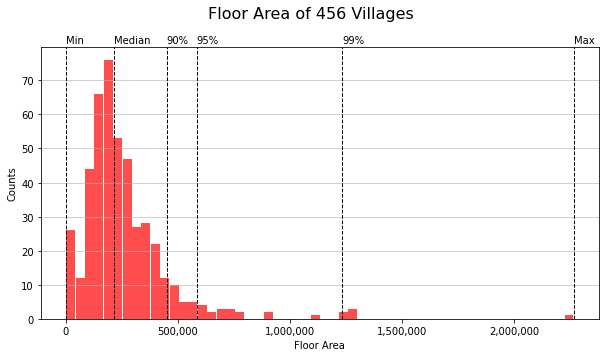

In [ ]:
x = tp_emp_df['fl_area_com_ind']

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(x, bins = 'auto', color='red', alpha=0.7, rwidth=0.95)
ax.grid(axis='y', alpha=0.75)
plt.axvline(0, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(215302.00, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(449436.50, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(583796.50, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(1232075.65, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(2266759.00, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.text(0, 81, "Min")
plt.text(215302.00, 81, "Median")
plt.text(449436, 81, "90%")
plt.text(583796, 81, "95%")
plt.text(1232075, 81, "99%")
plt.text(2266759.00, 81, "Max")
plt.xlabel('Floor Area')
plt.ylabel('Counts')
plt.figtext(.5,0.96,'Floor Area of 456 Villages', fontsize=16, ha='center')
ax.ticklabel_format(useOffset=False)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(
        tkr.FuncFormatter(lambda x,  p: format(int(x), ',')))

plt.show()

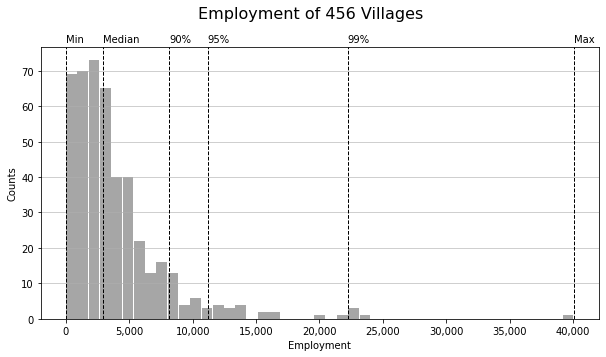

In [ ]:
x = tp_emp_df['vill_emp']

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(x, bins = 'auto', color='gray', alpha=0.7, rwidth=0.95)
ax.grid(axis='y', alpha=0.75)
plt.axvline(0, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(2893.56, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(8152.81, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(11198.80, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(22240.37, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(40065.10, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.text(0, 78, "Min")
plt.text(2893, 78, "Median")
plt.text(8152, 78, "90%")
plt.text(11198, 78, "95%")
plt.text(22240, 78, "99%")
plt.text(40065, 78, "Max")
plt.xlabel('Employment')
plt.ylabel('Counts')
plt.figtext(.5,0.96,'Employment of 456 Villages', fontsize=16, ha='center')
ax.ticklabel_format(useOffset=False)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(
        tkr.FuncFormatter(lambda x,  p: format(int(x), ',')))

plt.show()

# ADJUST BETWEENNESS AND TRAVEL DELAY BY NODES' WEIGHTS 

## Data preparation

### Nodes' weights: residents and employment

In [ ]:
# read population data
ppl = pd.read_excel('https://github.com/dubidub/Coursera_Capstone/raw/master/Taipei%20Neighborhoods%20population%202019.xlsx')
ppl["town_vill"] = ppl["行政區"] + ppl["村里"]
ppl.rename(columns = {'總計': 'vill_residents'}, inplace=True)
ppl = ppl[['town_vill', 'vill_residents']]
ppl = ppl.sort_values(by='vill_residents', ascending=False).iloc[13:]
ppl.replace('萬華區糖廍里', '萬華區糖蔀里', inplace=True)
# merge with employment dataframe 
tp_emp_df["town_vill"] = tp_emp_df["town"] + tp_emp_df["village"]
tp_emp_res = tp_emp_df.merge(ppl, on='town_vill')
tp_emp_res = tp_emp_res[['town_vill', 'town_eng', 'village_eng', 'vill_emp', 'vill_residents']]

tp_emp_res

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,town_vill,town_eng,village_eng,vill_emp,vill_residents
0,松山區莊敬里,Songshan,Zhuangjing Vil.,3029.448496,5446
1,松山區東榮里,Songshan,Dongrong Vil.,10022.325240,8218
2,松山區三民里,Songshan,Sanmin Vil.,4174.282768,6962
3,松山區新益里,Songshan,Xinyi Vil.,3245.275751,4679
4,松山區富錦里,Songshan,Fujin Vil.,4209.539201,5318
...,...,...,...,...,...
451,北投區關渡里,Beitou,Guandu Vil.,1467.292698,11836
452,北投區泉源里,Beitou,Quanyuan Vil.,0.000000,2425
453,北投區湖山里,Beitou,Hushan Vil.,0.000000,1660
454,北投區大屯里,Beitou,Datun Vil.,0.000000,1277


In [ ]:
tp_emp_res.describe()

,vill_emp,vill_residents
count,456.000000,456.000000
mean,3926.453947,5800.528509
std,4080.633003,2049.630137
min,0.000000,939.000000
25%,1414.925232,4429.250000
50%,2893.561274,5611.500000
75%,4864.425514,7123.500000
max,40065.101607,11836.000000


### Routing (betweenness centrality) Travel Delay and of nodes

In [ ]:
# read travel time data of 456x456 routes
travelTime_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Taipei Transportation/travelTime/travelTime_df.csv')
# correct wrong words
travelTime_df.replace('萬華區糖廍里', '萬華區糖蔀里', inplace=True)
# read routing data
shortest_paths_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Taipei Transportation/shortestPaths/shortest_paths_df_20210125.csv')
shortest_paths_df.drop(columns = ['Unnamed: 0'], inplace=True)
# convert string to list
for i in range(len(shortest_paths_df)):
  route = ast.literal_eval(shortest_paths_df['shortest_paths_rev'][i]) 
  shortest_paths_df['shortest_paths_rev'][i] = route
# create an OD column for mapping
shortest_paths_df['OD'] = shortest_paths_df['origin'] + '-' + shortest_paths_df['destination']
shortest_paths_df
# merge travel time data with routing data 
travelTime_df['OD'] = travelTime_df['origin'] + '-' + travelTime_df['destination'] # add column for mapping
edge_delay_df_1 = travelTime_df[['origin', 'destination', 'OD', 'trafficTime', 'baseTime']]
edge_delay_df_2 = shortest_paths_df[['OD', 'shortest_paths_rev']]
edge_delay_df = edge_delay_df_1.merge(edge_delay_df_2, on='OD')
edge_delay_df

,origin,destination,OD,trafficTime,baseTime,shortest_paths_rev
0,中山區下埤里,中山區下埤里,中山區下埤里-中山區下埤里,0,0,"[中山區下埤里, 中山區下埤里]"
1,中山區下埤里,中山區中原里,中山區下埤里-中山區中原里,574,516,"[中山區下埤里, 中山區行仁里, 中山區行政里, 中山區松江里, 中山區中央里, 中山區中吉..."
2,中山區下埤里,中山區中吉里,中山區下埤里-中山區中吉里,467,412,"[中山區下埤里, 中山區行仁里, 中山區行政里, 中山區松江里, 中山區中央里, 中山區中吉里]"
3,中山區下埤里,中山區中央里,中山區下埤里-中山區中央里,461,418,"[中山區下埤里, 中山區行仁里, 中山區行政里, 中山區松江里, 中山區中央里]"
4,中山區下埤里,中山區中山里,中山區下埤里-中山區中山里,657,596,"[中山區下埤里, 中山區行仁里, 中山區行政里, 中山區新福里, 中山區恆安里, 中山區聚葉..."
...,...,...,...,...,...,...
207931,萬華區騰雲里,萬華區錦德里,萬華區騰雲里-萬華區錦德里,455,433,"[萬華區騰雲里, 萬華區凌霄里, 萬華區新和里, 萬華區新安里, 萬華區日善里, 萬華區忠德..."
207932,萬華區騰雲里,萬華區雙園里,萬華區騰雲里-萬華區雙園里,337,289,"[萬華區騰雲里, 萬華區凌霄里, 萬華區新和里, 萬華區新忠里, 萬華區頂碩里, 萬華區雙園里]"
207933,萬華區騰雲里,萬華區青山里,萬華區騰雲里-萬華區青山里,580,468,"[萬華區騰雲里, 萬華區凌霄里, 萬華區新和里, 萬華區新忠里, 萬華區頂碩里, 中正區廈安..."
207934,萬華區騰雲里,萬華區頂碩里,萬華區騰雲里-萬華區頂碩里,260,218,"[萬華區騰雲里, 萬華區凌霄里, 萬華區新和里, 萬華區新忠里, 萬華區頂碩里]"


In [ ]:
# find all route that passes by specific nodes and its traffic time and base time
nodes_routes_dict = {}
trafficTime = {}
baseTime = {}
ori_residents = {}
des_emp = {}

for i in range(len(edge_delay_df)):
  if edge_delay_df['origin'][i] != edge_delay_df['destination'][i]:
    for j in edge_delay_df['shortest_paths_rev'][i]:
      if j not in nodes_routes_dict:
        nodes_routes_dict[j] = []
        trafficTime[j] = []
        baseTime[j] = []
        ori_residents[j] = []
        des_emp[j] = []
      if j != edge_delay_df['origin'][i] and j != edge_delay_df['destination'][i]:
        nodes_routes_dict[j].append(edge_delay_df['OD'][i])
        trafficTime[j].append(edge_delay_df['trafficTime'][i])
        baseTime[j].append(edge_delay_df['baseTime'][i])
        ori_residents[j].append(edge_delay_df['ori_residents'][i])
        des_emp[j].append(edge_delay_df['des_emp'][i])
      
keys_values = des_emp.items()
des_emp = {key: str(value) for key, value in keys_values}
des_emp_df = pd.DataFrame.from_dict(des_emp, orient='index')
des_emp_df.reset_index(inplace=True)
des_emp_df.rename(columns={'index': 'node', 0: 'des_emp'}, inplace=True)

keys_values = ori_residents.items()
ori_residents = {key: str(value) for key, value in keys_values}
ori_residents_df = pd.DataFrame.from_dict(ori_residents, orient='index')
ori_residents_df.reset_index(inplace=True)
ori_residents_df.rename(columns={'index': 'node', 0: 'ori_residents'}, inplace=True)

keys_values = trafficTime.items()
trafficTime = {key: str(value) for key, value in keys_values}
trafficTime_df = pd.DataFrame.from_dict(trafficTime, orient='index')
trafficTime_df.reset_index(inplace=True)
trafficTime_df.rename(columns={'index': 'node', 0: 'trafficTime'}, inplace=True)

keys_values = baseTime.items()
baseTime = {key: str(value) for key, value in keys_values}
baseTime_df = pd.DataFrame.from_dict(baseTime, orient='index')
baseTime_df.reset_index(inplace=True)
baseTime_df.rename(columns={'index': 'node', 0: 'baseTime'}, inplace=True)

keys_values = nodes_routes_dict.items()
nodes_routes_dict = {key: str(value) for key, value in keys_values}
nodes_routes_df = pd.DataFrame.from_dict(nodes_routes_dict, orient='index')
nodes_routes_df.reset_index(inplace=True)
nodes_routes_df.rename(columns={'index': 'node', 0: 'routes'}, inplace=True)

node_route_delay_df = nodes_routes_df.merge(trafficTime_df, on='node')
node_route_delay_df = node_route_delay_df.merge(baseTime_df, on='node')
node_route_delay_df = node_route_delay_df.merge(ori_residents_df, on='node')
node_route_delay_df = node_route_delay_df.merge(des_emp_df, on='node')
node_route_delay_df

,node,routes,trafficTime,baseTime,ori_residents,des_emp
0,中山區下埤里,"['中山區劍潭里-中山區中吉里', '中山區劍潭里-中山區中央里', '中山區劍潭里-中山區...","[804, 820, 820, 775, 896, 760, 676, 687, 687, ...","[697, 725, 725, 686, 764, 661, 607, 604, 604, ...","[3822.0, 3822.0, 3822.0, 3822.0, 3822.0, 3822....","[8888.185677905734, 8643.188285204315, 8643.18..."
1,中山區行仁里,"['中山區下埤里-中山區中原里', '中山區下埤里-中山區中吉里', '中山區下埤里-中山區...","[574, 467, 461, 657, 444, 445, 182, 590, 412, ...","[516, 412, 418, 596, 417, 383, 160, 491, 380, ...","[7649.0, 7649.0, 7649.0, 7649.0, 7649.0, 7649....","[5808.239091946428, 8888.185677905734, 8643.18..."
2,中山區行政里,"['中山區下埤里-中山區中原里', '中山區下埤里-中山區中吉里', '中山區下埤里-中山區...","[574, 467, 461, 657, 444, 445, 590, 412, 306, ...","[516, 412, 418, 596, 417, 383, 491, 380, 292, ...","[7649.0, 7649.0, 7649.0, 7649.0, 7649.0, 7649....","[5808.239091946428, 8888.185677905734, 8643.18..."
3,中山區松江里,"['中山區下埤里-中山區中原里', '中山區下埤里-中山區中吉里', '中山區下埤里-中山區...","[574, 467, 461, 601, 648, 744, 909, 1145, 913,...","[516, 412, 418, 522, 578, 668, 802, 966, 824, ...","[7649.0, 7649.0, 7649.0, 7649.0, 7649.0, 7649....","[5808.239091946428, 8888.185677905734, 8643.18..."
4,中山區中央里,"['中山區下埤里-中山區中原里', '中山區下埤里-中山區中吉里', '中山區下埤里-中山區...","[574, 467, 601, 648, 744, 909, 1145, 913, 691,...","[516, 412, 522, 578, 668, 802, 966, 824, 606, ...","[7649.0, 7649.0, 7649.0, 7649.0, 7649.0, 7649....","[5808.239091946428, 8888.185677905734, 15357.3..."
...,...,...,...,...,...,...
452,萬華區富福里,"['中山區下埤里-萬華區雙園里', '中山區中原里-中正區廈安里', '中山區中原里-中正區...","[1270, 1036, 1070, 1246, 1246, 1142, 1096, 109...","[1053, 838, 866, 1050, 1050, 947, 892, 892, 95...","[7649.0, 5192.0, 5192.0, 5192.0, 5192.0, 5192....","[1167.7962333476548, 2263.274829227327, 2587.2..."
453,萬華區忠德里,"['中山區下埤里-萬華區錦德里', '中山區中原里-萬華區錦德里', '中山區中吉里-萬華區...","[1345, 1092, 1141, 1086, 1079, 954, 1142, 1459...","[1152, 951, 1002, 943, 950, 854, 996, 1277, 89...","[7649.0, 5192.0, 5891.0, 3787.0, 6851.0, 6851....","[1133.838658319859, 1133.838658319859, 1133.83..."
454,萬華區日善里,"['中山區中原里-萬華區保德里', '中山區中原里-萬華區保德里', '中山區中原里-萬華區...","[1246, 1246, 1142, 1276, 1276, 1169, 1066, 106...","[1050, 1050, 947, 1084, 1084, 981, 907, 907, 8...","[5192.0, 5192.0, 5192.0, 5891.0, 5891.0, 5891....","[872.8824968643248, 872.8824968643248, 1031.21..."
455,萬華區雙園里,"['中山區中原里-萬華區和平里', '中山區中吉里-萬華區和平里', '中山區中央里-萬華區...","[1096, 1118, 1078, 908, 1159, 1486, 1084, 1597...","[892, 926, 866, 749, 997, 1247, 935, 1339, 946...","[5192.0, 5891.0, 3787.0, 6851.0, 5161.0, 3822....","[1028.445075666176, 1028.445075666176, 1028.44..."


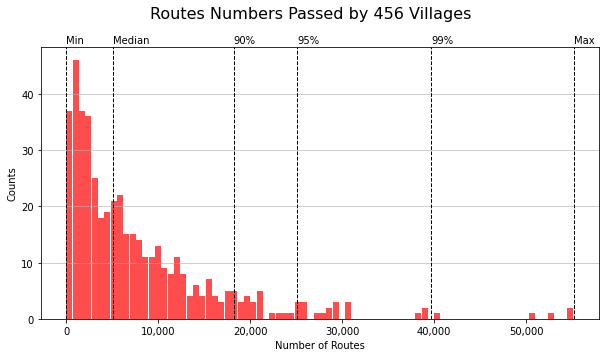

In [ ]:
# distribution of passing by shortest routes (betweenness)
node_route_delay_df['routes_no'] = pd.Series([])
for i in range(len(node_route_delay_df)):
  node_route_delay_df['routes_no'][i] = len(set(node_route_delay_df['routes'][i]))

x = node_route_delay_df['routes_no']

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(x, bins = 80, color='red', alpha=0.7, rwidth=0.95)
ax.grid(axis='y', alpha=0.75)
plt.axvline(0, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(5110.0, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(18240, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(25148.80, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(39677.56, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(55171.0, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.text(0, 49, "Min")
plt.text(5110.0, 49, "Median")
plt.text(18240, 49, "90%")
plt.text(25148, 49, "95%")
plt.text(39677, 49, "99%")
plt.text(55171, 49, "Max")
plt.xlabel('Number of Routes')
plt.ylabel('Counts')
plt.figtext(.5,0.96,'Routes Numbers Passed by 456 Villages', fontsize=16, ha='center')
ax.ticklabel_format(useOffset=False)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(
        tkr.FuncFormatter(lambda x,  p: format(int(x), ',')))

plt.show()

### Routing (betweenness centrality) Travel Delay and of Edges

In [ ]:
# convert route list consisting of nodes to list consisting of edges
edge_delay_df['shortest_path_edges'] = pd.Series([])
for j in range(len(edge_delay_df)):
  if edge_delay_df['origin'][j] != edge_delay_df['destination'][j]:
    path = [item for item in edge_delay_df['shortest_paths_rev'][j] if item != 'NA'] 
    edge_list = []
    for i in range(1,len(path)):    
      edge = path[i-1] + '-' + path[i]
      if edge not in edge_list:
        edge_list.append(edge)
    edge_delay_df['shortest_path_edges'][j] = edge_list

edge_delay_df['ori_residents'] = pd.Series([])
edge_delay_df['des_emp'] = pd.Series([])

for i in range(len(edge_delay_df)):
  ori = edge_delay_df['origin'][i]
  des = edge_delay_df['destination'][i]
  edge_delay_df['ori_residents'][i] = tp_emp_res[tp_emp_res['town_vill'] == ori]['vill_residents'].values[0]
  edge_delay_df['des_emp'][i] = tp_emp_res[tp_emp_res['town_vill'] == des]['vill_emp'].values[0]

edge_delay_df.head(3)

,origin,destination,OD,trafficTime,baseTime,shortest_paths_rev,shortest_path_edges,ori_residents,des_emp
0,中山區下埤里,中山區下埤里,中山區下埤里-中山區下埤里,0,0,"[中山區下埤里, 中山區下埤里]",NaN,7649.0,6128.714750
1,中山區下埤里,中山區中原里,中山區下埤里-中山區中原里,574,516,"[中山區下埤里, 中山區行仁里, 中山區行政里, 中山區松江里, 中山區中央里, 中山區中吉...","[中山區下埤里-中山區行仁里, 中山區行仁里-中山區行政里, 中山區行政里-中山區松江里, ...",7649.0,5808.239092
2,中山區下埤里,中山區中吉里,中山區下埤里-中山區中吉里,467,412,"[中山區下埤里, 中山區行仁里, 中山區行政里, 中山區松江里, 中山區中央里, 中山區中吉里]","[中山區下埤里-中山區行仁里, 中山區行仁里-中山區行政里, 中山區行政里-中山區松江里, ...",7649.0,8888.185678


In [ ]:
# find all route that passes by specific edges and its traffic time and base time
edges_routes_dict = {}
trafficTime = {}
baseTime = {}
ori_residents = {}
des_emp = {}

for i in range(len(edge_delay_df)):
  if edge_delay_df['origin'][i] != edge_delay_df['destination'][i]:
    for j in edge_delay_df['shortest_path_edges'][i]:
      if j not in edges_routes_dict:
        edges_routes_dict[j] = []
        trafficTime[j] = []
        baseTime[j] = []
        ori_residents[j] = []
        des_emp[j] = []
      edges_routes_dict[j].append(edge_delay_df['OD'][i])
      trafficTime[j].append(edge_delay_df['trafficTime'][i])
      baseTime[j].append(edge_delay_df['baseTime'][i])
      ori_residents[j].append(edge_delay_df['ori_residents'][i])
      des_emp[j].append(edge_delay_df['des_emp'][i])
      
keys_values = des_emp.items()
des_emp = {key: str(value) for key, value in keys_values}
des_emp_df = pd.DataFrame.from_dict(des_emp, orient='index')
des_emp_df.reset_index(inplace=True)
des_emp_df.rename(columns={'index': 'edge', 0: 'des_emp'}, inplace=True)

keys_values = ori_residents.items()
ori_residents = {key: str(value) for key, value in keys_values}
ori_residents_df = pd.DataFrame.from_dict(ori_residents, orient='index')
ori_residents_df.reset_index(inplace=True)
ori_residents_df.rename(columns={'index': 'edge', 0: 'ori_residents'}, inplace=True)

keys_values = trafficTime.items()
trafficTime = {key: str(value) for key, value in keys_values}
trafficTime_df = pd.DataFrame.from_dict(trafficTime, orient='index')
trafficTime_df.reset_index(inplace=True)
trafficTime_df.rename(columns={'index': 'edge', 0: 'trafficTime'}, inplace=True)

keys_values = baseTime.items()
baseTime = {key: str(value) for key, value in keys_values}
baseTime_df = pd.DataFrame.from_dict(baseTime, orient='index')
baseTime_df.reset_index(inplace=True)
baseTime_df.rename(columns={'index': 'edge', 0: 'baseTime'}, inplace=True)

keys_values = edges_routes_dict.items()
edges_routes_dict = {key: str(value) for key, value in keys_values}
edges_routes_df = pd.DataFrame.from_dict(edges_routes_dict, orient='index')
edges_routes_df.reset_index(inplace=True)
edges_routes_df.rename(columns={'index': 'edge', 0: 'routes'}, inplace=True)

edge_route_delay_df = edges_routes_df.merge(trafficTime_df, on='edge')
edge_route_delay_df = edge_route_delay_df.merge(baseTime_df, on='edge')
edge_route_delay_df = edge_route_delay_df.merge(ori_residents_df, on='edge')
edge_route_delay_df = edge_route_delay_df.merge(des_emp_df, on='edge')
edge_route_delay_df

,edge,routes,trafficTime,baseTime,ori_residents,des_emp
0,中山區下埤里-中山區行仁里,"['中山區下埤里-中山區中原里', '中山區下埤里-中山區中吉里', '中山區下埤里-中山區...","[574, 467, 461, 657, 444, 445, 182, 590, 412, ...","[516, 412, 418, 596, 417, 383, 160, 491, 380, ...","[7649.0, 7649.0, 7649.0, 7649.0, 7649.0, 7649....","[5808.239091946428, 8888.185677905734, 8643.18..."
1,中山區行仁里-中山區行政里,"['中山區下埤里-中山區中原里', '中山區下埤里-中山區中吉里', '中山區下埤里-中山區...","[574, 467, 461, 657, 444, 412, 429, 324, 466, ...","[516, 412, 418, 596, 417, 380, 399, 297, 421, ...","[7649.0, 7649.0, 7649.0, 7649.0, 7649.0, 7649....","[5808.239091946428, 8888.185677905734, 8643.18..."
2,中山區行政里-中山區松江里,"['中山區下埤里-中山區中原里', '中山區下埤里-中山區中吉里', '中山區下埤里-中山區...","[574, 467, 461, 601, 356, 648, 744, 909, 1145,...","[516, 412, 418, 522, 326, 578, 668, 802, 966, ...","[7649.0, 7649.0, 7649.0, 7649.0, 7649.0, 7649....","[5808.239091946428, 8888.185677905734, 8643.18..."
3,中山區松江里-中山區中央里,"['中山區下埤里-中山區中原里', '中山區下埤里-中山區中吉里', '中山區下埤里-中山區...","[574, 467, 461, 601, 648, 744, 909, 1145, 913,...","[516, 412, 418, 522, 578, 668, 802, 966, 824, ...","[7649.0, 7649.0, 7649.0, 7649.0, 7649.0, 7649....","[5808.239091946428, 8888.185677905734, 8643.18..."
4,中山區中央里-中山區中吉里,"['中山區下埤里-中山區中原里', '中山區下埤里-中山區中吉里', '中山區下埤里-中山區...","[574, 467, 648, 235, 242, 312, 312, 268, 348, ...","[516, 412, 578, 205, 224, 262, 279, 238, 292, ...","[7649.0, 7649.0, 7649.0, 3787.0, 3787.0, 3787....","[5808.239091946428, 8888.185677905734, 10104.8..."
...,...,...,...,...,...,...
2065,萬華區全德里-萬華區忠德里,"['萬華區新忠里-萬華區錦德里', '萬華區日善里-萬華區和德里', '萬華區日善里-萬華區...","[304, 302, 255]","[302, 270, 253]","[3464.0, 3831.0, 3831.0]","[1133.838658319859, 1428.5009049767395, 1133.8..."
2066,萬華區忠貞里-萬華區新和里,"['萬華區日祥里-中正區廈安里', '萬華區日祥里-中正區忠勤里', '萬華區日祥里-萬華區...","[355, 314, 231, 250, 396, 330]","[301, 272, 189, 208, 333, 275]","[6098.0, 6098.0, 6098.0, 6098.0, 6098.0, 4768.0]","[2263.274829227327, 2587.2291872450114, 1278.4..."
2067,萬華區日善里-萬華區和德里,['萬華區日祥里-萬華區和德里'],[501],[409],[6098.0],[1428.5009049767395]
2068,萬華區柳鄉里-北投區關渡里,['萬華區柳鄉里-北投區關渡里'],[1718],[1457],[5287.0],[1467.2926984210726]


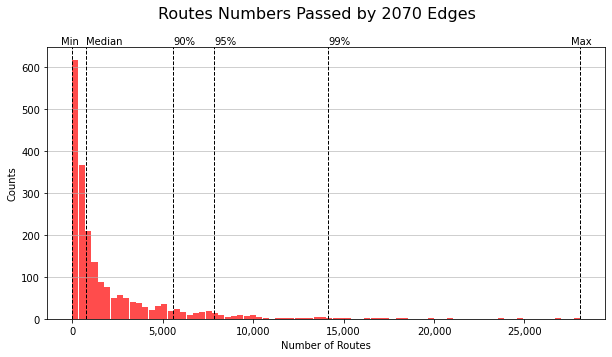

In [ ]:
# distribution of passing by routes (edges' betweenness)
edge_route_delay_df['routes_no'] = pd.Series([])
for i in range(len(edge_route_delay_df)):
  edge_route_delay_df['routes_no'][i] = len(set(edge_route_delay_df['routes'][i]))

x = edge_route_delay_df['routes_no']

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(x, bins = 80, color='red', alpha=0.7, rwidth=0.95)
ax.grid(axis='y', alpha=0.75)
plt.axvline(1, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(760.0, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(5596.20, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(7843.15, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(14160.28, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.axvline(28063.0, color = 'black', linestyle = 'dashed', linewidth = 1)
plt.text(-600, 655, "Min")
plt.text(760.0, 655, "Median")
plt.text(5596, 655, "90%")
plt.text(7843, 655, "95%")
plt.text(14160, 655, "99%")
plt.text(27563.0, 655, "Max")
plt.xlabel('Number of Routes')
plt.ylabel('Counts')
plt.figtext(.5,0.96,'Routes Numbers Passed by 2070 Edges', fontsize=16, ha='center')
ax.ticklabel_format(useOffset=False)
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(
        tkr.FuncFormatter(lambda x,  p: format(int(x), ',')))

plt.show()

## Calculation of weighted average travel delay and weighted betweenness

### Nodes

In [ ]:
travel_delay = []
weighted_delay = []
denominators = []
numerators = []
for i in range(len(node_route_delay_df)): 
  trafficTime = node_route_delay_df['trafficTime'][i]
  baseTime = node_route_delay_df['baseTime'][i]
  ori_residents = node_route_delay_df['ori_residents'][i]
  des_emp = node_route_delay_df['des_emp'][i]
  routes_no = int(node_route_delay_df['routes_no'][i])
  denominator = 0
  numerator = 0
  delays = []
  for j in range(routes_no):
    if baseTime[j] != 0:
      delays.append(trafficTime[j] / baseTime[j] -1)
      denominator += ori_residents[j] * des_emp[j]
      numerator += ori_residents[j] * des_emp[j] * ( trafficTime[j] / baseTime[j] -1 )
  if denominator != 0:
    weighted_delay.append(numerator/denominator)
  else:
    weighted_delay.append(0)
  if len(delays) != 0:
    travel_delay.append(sum(delays)/len(delays))
  else:
    travel_delay.append(0)
  denominators.append(denominator)
  numerators.append(numerator)
node_route_delay_df['weighted_delay'] = pd.Series(weighted_delay)
node_route_delay_df['denominators'] = pd.Series(denominators)
node_route_delay_df['numerators'] = pd.Series(numerators)
node_route_delay_df['travel_delay'] = pd.Series(travel_delay)

In [ ]:
sum_res_emp = sum(edge_delay_df['ori_residents'] * edge_delay_df['des_emp'])
node_route_delay_df['bet'] = node_route_delay_df['routes_no'] / (456*455)
node_route_delay_df['weighted_bet'] = node_route_delay_df['denominators'] / sum_res_emp
node_bet_delay = node_route_delay_df[['node', 'bet', 'weighted_bet', 'travel_delay', 'weighted_delay']]
node_bet_delay.drop(456, inplace=True) # remove N/A
node_bet_delay

,node,bet,weighted_bet,travel_delay,weighted_delay
0,中山區下埤里,0.025443,0.030806,0.175084,0.195080
1,中山區行仁里,0.071038,0.077287,0.275345,0.273386
2,中山區行政里,0.094033,0.092862,0.279876,0.284683
3,中山區松江里,0.071602,0.078129,0.230334,0.246680
4,中山區中央里,0.075337,0.079837,0.221923,0.237555
...,...,...,...,...,...
451,萬華區富民里,0.006796,0.004788,0.212053,0.214664
452,萬華區富福里,0.030037,0.014986,0.231194,0.278510
453,萬華區忠德里,0.008362,0.004724,0.293220,0.359499
454,萬華區日善里,0.012772,0.004667,0.216099,0.274505


### Edges

In [ ]:
travel_delay = []
weighted_delay = []
denominators = []
numerators = []
for i in range(len(edge_route_delay_df)): 
  trafficTime = edge_route_delay_df['trafficTime'][i]
  baseTime = edge_route_delay_df['baseTime'][i]
  ori_residents = edge_route_delay_df['ori_residents'][i]
  des_emp = edge_route_delay_df['des_emp'][i]
  routes_no = int(edge_route_delay_df['routes_no'][i])
  denominator = 0
  numerator = 0
  delays = []
  for j in range(routes_no):
    if baseTime[j] != 0:
      delays.append(trafficTime[j] / baseTime[j] -1)
      denominator += ori_residents[j] * des_emp[j]
      numerator += ori_residents[j] * des_emp[j] * ( trafficTime[j] / baseTime[j] -1 )
  if denominator != 0:
    weighted_delay.append(numerator/denominator)
  else:
    weighted_delay.append(0)
  if len(delays) != 0:
    travel_delay.append(sum(delays)/len(delays))
  else:
    travel_delay.append(0)
  denominators.append(denominator)
  numerators.append(numerator)

edge_route_delay_df['denominators'] = pd.Series(denominators)
edge_route_delay_df['numerators'] = pd.Series(numerators)
edge_route_delay_df['travel_delay'] = pd.Series(travel_delay)
edge_route_delay_df['weighted_delay'] = pd.Series(weighted_delay)
edge_route_delay_df

In [ ]:
sum_res_emp = sum(edge_delay_df['ori_residents'] * edge_delay_df['des_emp'])
edge_route_delay_df['bet'] = edge_route_delay_df['routes_no'] / (456*455)
edge_route_delay_df['weighted_bet'] = edge_route_delay_df['denominators'] / sum_res_emp
edge_bet_delay = edge_route_delay_df[['edge', 'bet', 'weighted_bet', 'travel_delay', 'weighted_delay']]
edge_bet_delay

,edge,bet,weighted_bet,travel_delay,weighted_delay
0,中山區下埤里-中山區行仁里,0.018084,0.020236,0.166252,0.170983
1,中山區行仁里-中山區行政里,0.028432,0.032788,0.207388,0.215778
2,中山區行政里-中山區松江里,0.027463,0.021430,0.208450,0.223210
3,中山區松江里-中山區中央里,0.063360,0.064808,0.226135,0.243177
4,中山區中央里-中山區中吉里,0.004068,0.008802,0.233166,0.233973
...,...,...,...,...,...
2065,萬華區全德里-萬華區忠德里,0.000014,0.000003,0.044349,0.051583
2066,萬華區忠貞里-萬華區新和里,0.000029,0.000011,0.191191,0.182691
2067,萬華區日善里-萬華區和德里,0.000005,0.000002,0.224939,0.224939
2068,萬華區柳鄉里-北投區關渡里,0.000005,0.000002,0.179135,0.179135


## Distribution of Weighted Betweenness and travel delay

### Nodes

In [ ]:
node_bet_delay.quantile([0, .01, .05, .1, .5, .9, .95, .99, 1])

,bet,weighted_bet,travel_delay,weighted_delay
0.00,0.000000,0.000000,0.000000,0.000000
0.01,0.000000,0.000000,0.000000,0.000000
0.05,0.001524,0.000542,0.164626,0.169050
0.10,0.004331,0.002222,0.184343,0.195990
0.50,0.024646,0.019942,0.225101,0.240255
0.90,0.087948,0.084772,0.271668,0.296522
0.95,0.121241,0.113552,0.291872,0.318600
0.99,0.191299,0.194684,0.319308,0.383517
1.00,0.265910,0.257384,0.344178,0.427184


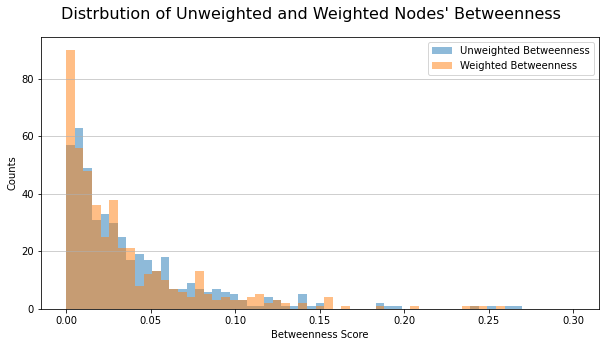

In [ ]:
bet = node_bet_delay['bet']
w_bet = node_bet_delay['weighted_bet']

bins = np.linspace(0, 0.3, 60)

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(bet, bins=bins, alpha=0.5, label='Unweighted Betweenness')
ax.hist(w_bet, bins=bins, alpha=0.5, label='Weighted Betweenness')
ax.grid(axis='y', alpha=0.75)

plt.xlabel('Betweenness Score')
plt.ylabel('Counts')
plt.figtext(.5,0.93,"Distrbution of Unweighted and Weighted Nodes' Betweenness", fontsize=16, ha='center')
plt.legend(loc='upper right')

plt.show()

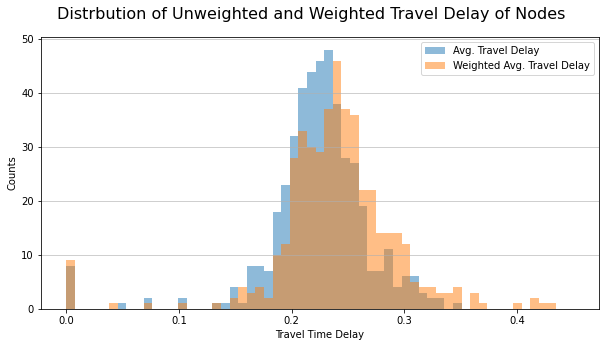

In [ ]:
delay = node_bet_delay['travel_delay']
w_delay = node_bet_delay['weighted_delay']

bins = np.linspace(0, 0.45, 60)

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(delay, bins=bins, alpha=0.5, label='Avg. Travel Delay')
ax.hist(w_delay, bins=bins, alpha=0.5, label='Weighted Avg. Travel Delay')
ax.grid(axis='y', alpha=0.75)

plt.xlabel('Travel Time Delay')
plt.ylabel('Counts')
plt.figtext(.5,0.93,"Distrbution of Unweighted and Weighted Travel Delay of Nodes", fontsize=16, ha='center')
plt.legend(loc='upper right')

plt.show()

### Edges

In [ ]:
edge_bet_delay.quantile([0, .5, .9, .95, .99, 1])

,bet,weighted_bet,travel_delay,weighted_delay
0.00,0.000005,0.000000,0.000000,0.000000
0.50,0.003663,0.003147,0.218785,0.227422
0.90,0.026972,0.024060,0.284361,0.299787
0.95,0.037802,0.038964,0.316560,0.332674
0.99,0.068249,0.066520,0.384714,0.409929
1.00,0.135256,0.167511,0.508045,0.556669


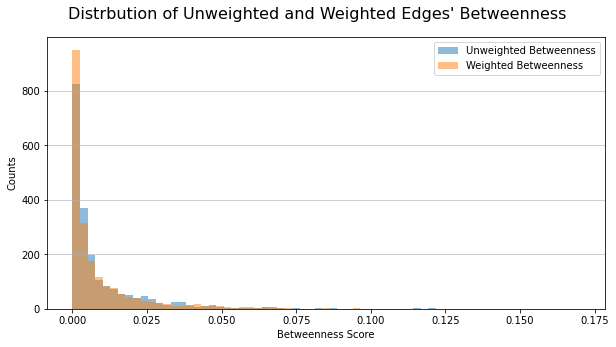

In [ ]:
bet = edge_bet_delay['bet']
w_bet = edge_bet_delay['weighted_bet']

bins = np.linspace(0, 0.17, 68)

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(bet, bins=bins, alpha=0.5, label='Unweighted Betweenness')
ax.hist(w_bet, bins=bins, alpha=0.5, label='Weighted Betweenness')
ax.grid(axis='y', alpha=0.75)

plt.xlabel('Betweenness Score')
plt.ylabel('Counts')
plt.figtext(.5,0.93,"Distrbution of Unweighted and Weighted Edges' Betweenness", fontsize=16, ha='center')
plt.legend(loc='upper right')

plt.show()

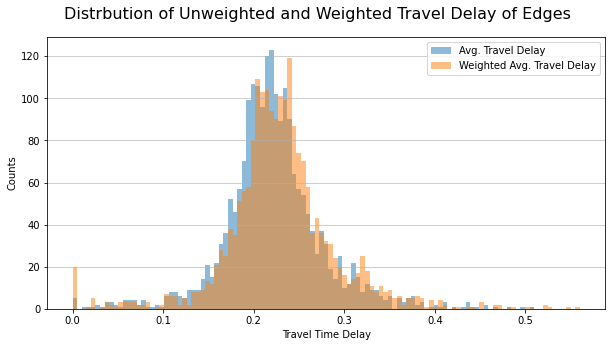

In [ ]:
delay = edge_bet_delay['travel_delay']
w_delay = edge_bet_delay['weighted_delay']

bins = np.linspace(0, 0.56, 112)

fig, ax = plt.subplots(figsize=(10,5))
ax.hist(delay, bins=bins, alpha=0.5, label='Avg. Travel Delay')
ax.hist(w_delay, bins=bins, alpha=0.5, label='Weighted Avg. Travel Delay')
ax.grid(axis='y', alpha=0.75)

plt.xlabel('Travel Time Delay')
plt.ylabel('Counts')
plt.figtext(.5,0.93,"Distrbution of Unweighted and Weighted Travel Delay of Edges", fontsize=16, ha='center')
plt.legend(loc='upper right')

plt.show()

# ANALYSIS

## Nodes

### Scatter Plot of betweenness and travel delay

In [ ]:
node_bet_delay.quantile([0, .5, .9, .95, .99, 1])

,bet,weighted_bet,travel_delay,weighted_delay
0.00,0.000000,0.000000,0.000000,0.000000
0.50,0.024646,0.019942,0.225101,0.240255
0.90,0.087948,0.084772,0.271668,0.296522
0.95,0.121241,0.113552,0.291872,0.318600
0.99,0.191299,0.194684,0.319308,0.383517
1.00,0.265910,0.257384,0.344178,0.427184


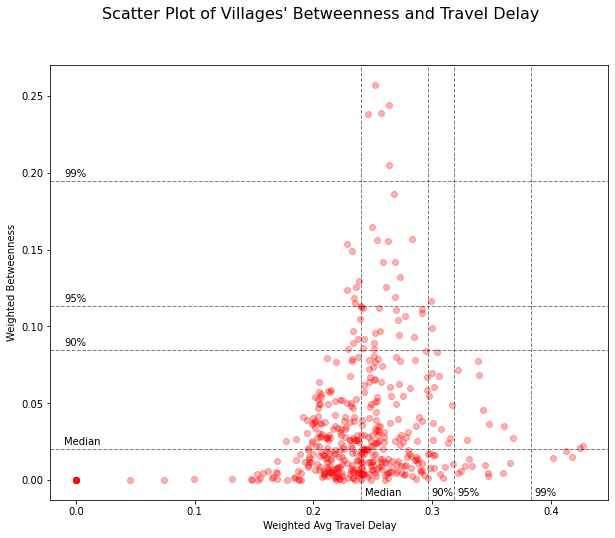

In [ ]:
w_delay = node_bet_delay['weighted_delay']
w_bet = node_bet_delay['weighted_bet']

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(w_delay, w_bet, marker='o', c='Red', alpha=0.3)

plt.axvline(.240171, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(.296522, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(.318393, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(.383176, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.text(.243171, -.01, "Median")
plt.text(.299522, -.01, "90%")
plt.text(.321393, -.01, "95%")
plt.text(.386176, -.01, "99%")

plt.axhline(0.019938, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.084772, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.113454, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.194499, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.text(-.01, .022938, "Median")
plt.text(-.01, .087772, "90%")
plt.text(-.01, .116454, "95%")
plt.text(-.01, .197499, "99%")

plt.xlabel('Weighted Avg Travel Delay')
plt.ylabel('Weighted Betweenness')
plt.figtext(.5,0.96,"Scatter Plot of Villages' Betweenness and Travel Delay", fontsize=16, ha='center')

plt.show()

### K-means Clustering

In [ ]:
# normalize weighted betweenness and travel delay
node_bet_delay['weighted_bet_norm'] = (node_bet_delay['weighted_bet'] - min(node_bet_delay['weighted_bet'])) / (max(node_bet_delay['weighted_bet']) - min(node_bet_delay['weighted_bet']))
node_bet_delay['weighted_delay_norm'] = (node_bet_delay['weighted_delay'] - min(node_bet_delay['weighted_delay'])) / (max(node_bet_delay['weighted_delay']) - min(node_bet_delay['weighted_delay']))
node_bet_delay

In [ ]:
node_clustering = node_bet_delay[['weighted_bet_norm', 'weighted_delay_norm']]
# parameter setting of k-means clustering
kclusters = 10
kmeans = KMeans(n_clusters = kclusters, random_state=0)
kmeans.fit(node_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
# result of clustering
node_clustering.insert(0, 'Cluster1', kmeans.labels_)
node_clustering = pd.concat([node_bet_delay['node'], node_clustering], axis=1)
node_clustering

,node,Cluster1,weighted_bet_norm,weighted_delay_norm
0,中山區下埤里,9,0.119690,0.456665
1,中山區行仁里,0,0.300281,0.639972
2,中山區行政里,0,0.360794,0.666418
3,中山區松江里,0,0.303549,0.577458
4,中山區中央里,0,0.310186,0.556097
...,...,...,...,...
451,萬華區富民里,8,0.018602,0.502510
452,萬華區富福里,4,0.058225,0.651968
453,萬華區忠德里,7,0.018355,0.841557
454,萬華區日善里,4,0.018131,0.642593


In [ ]:
# add percentile ranking 
node_bet_delay['weighted_bet_ranking'] = node_bet_delay['weighted_bet'].rank(pct=True)
node_bet_delay['weighted_delay_ranking'] = node_bet_delay['weighted_delay'].rank(pct=True)
node_bet_delay['weighted_bet_ranking'] = pd.Series(["{0:.0f}%".format(val * 100) for val in node_bet_delay['weighted_bet_ranking']], index = node_bet_delay.index)
node_bet_delay['weighted_delay_ranking'] = pd.Series(["{0:.0f}%".format(val * 100) for val in node_bet_delay['weighted_delay_ranking']], index = node_bet_delay.index)

node_bet_delay

,node,bet,weighted_bet,travel_delay,weighted_delay,weighted_bet_norm,weighted_delay_norm,weighted_bet_ranking,weighted_delay_ranking
0,中山區下埤里,0.025443,0.030806,0.175084,0.195080,0.119690,0.456665,65%,9%
1,中山區行仁里,0.071038,0.077287,0.275345,0.273386,0.300281,0.639972,87%,80%
2,中山區行政里,0.094033,0.092862,0.279876,0.284683,0.360794,0.666418,92%,85%
3,中山區松江里,0.071602,0.078129,0.230334,0.246680,0.303549,0.577458,88%,58%
4,中山區中央里,0.075337,0.079837,0.221923,0.237555,0.310186,0.556097,89%,47%
...,...,...,...,...,...,...,...,...,...
451,萬華區富民里,0.006796,0.004788,0.212053,0.214664,0.018602,0.502510,18%,26%
452,萬華區富福里,0.030037,0.014986,0.231194,0.278510,0.058225,0.651968,42%,83%
453,萬華區忠德里,0.008362,0.004724,0.293220,0.359499,0.018355,0.841557,18%,98%
454,萬華區日善里,0.012772,0.004667,0.216099,0.274505,0.018131,0.642593,17%,81%


In [ ]:
# add results to GeoJSON file for visulaization pupose 
for i in range(len(tp_df_geojson['features'])):
  town_vill = tp_df_geojson['features'][i]['properties']['里']
  cluster = int(node_clustering[node_clustering['node'] == town_vill]['Cluster1'])
  weighted_bet = float(node_bet_delay[node_bet_delay['node'] == town_vill]['weighted_bet'])
  weighted_delay = float(node_bet_delay[node_bet_delay['node'] == town_vill]['weighted_delay'])
  weighted_bet_ranking = node_bet_delay[node_bet_delay['node'] == town_vill]['weighted_bet_ranking'].tolist()[0]
  weighted_delay_ranking = node_bet_delay[node_bet_delay['node'] == town_vill]['weighted_delay_ranking'].tolist()[0]
  vill_residents = int(tp_emp_res[tp_emp_res['town_vill'] == town_vill]['vill_residents'])

  tp_df_geojson['features'][i]['properties']['Cluster'] = cluster
  tp_df_geojson['features'][i]['properties']['Weighted Betweenness'] = weighted_bet
  tp_df_geojson['features'][i]['properties']['Weighted Travel Time Delay'] = weighted_delay
  tp_df_geojson['features'][i]['properties']['Weighted Betweenness (ranking)'] = weighted_bet_ranking
  tp_df_geojson['features'][i]['properties']['Weighted Travel Time Delay (ranking)'] = weighted_delay_ranking
  tp_df_geojson['features'][i]['properties']['Residents'] = vill_residents

with open('tp_df_geojson.geojson', 'w') as f:
  dump(tp_df_geojson, f)
files.download('tp_df_geojson.geojson')

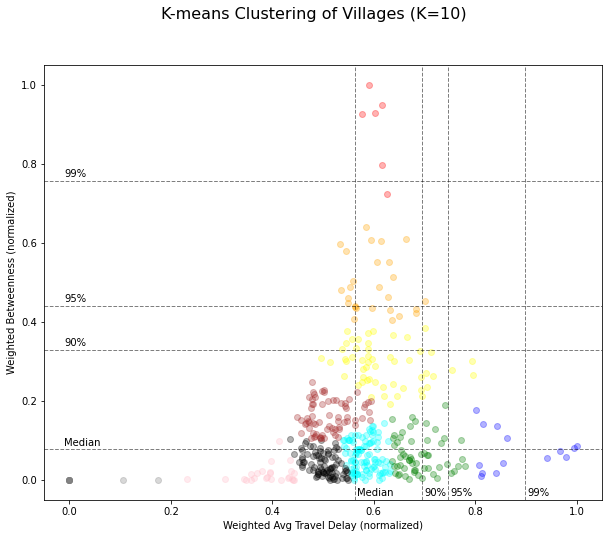

In [ ]:
# show clustering result on scatter plot
fig, ax = plt.subplots(figsize=(10,8))
color = ['Yellow', 'Cyan', 'Pink', 'Orange', 'Green', 'Gray', 'Red', 'Blue', 'Black', 'Brown']
for i in range(10):
  w_delay = node_bet_delay[node_clustering['Cluster1'] == i]['weighted_delay_norm']
  w_bet = node_bet_delay[node_clustering['Cluster1'] == i]['weighted_bet_norm']  
  ax.scatter(w_delay, w_bet, marker='o', c=color[i], alpha=0.3)

plt.axvline(0.562416, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(0.694134, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(0.745815, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(0.897779, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.text(.567416, -.04, "Median")
plt.text(.699134, -.04, "90%")
plt.text(.750815, -.04, "95%")
plt.text(.902779, -.04, "99%")

plt.axhline(0.077480, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.329362, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.441179, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.756395, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.text(-.01, .087480, "Median")
plt.text(-.01, .339362, "90%")
plt.text(-.01, .451179, "95%")
plt.text(-.01, .766395, "99%")

plt.xlabel('Weighted Avg Travel Delay (normalized)')
plt.ylabel('Weighted Betweenness (normalized)')
plt.figtext(.5,0.96,"K-means Clustering of Villages (K=10)", fontsize=16, ha='center')

plt.show()

## Edges

### Scatter Plot of betweenness and travel delay

In [ ]:
edge_bet_delay.quantile([0, .5, .9, .95, .99, 1])

,bet,weighted_bet,travel_delay,weighted_delay
0.00,0.000005,0.000000,0.000000,0.000000
0.50,0.003663,0.003147,0.218785,0.227422
0.90,0.026972,0.024060,0.284361,0.299787
0.95,0.037802,0.038964,0.316560,0.332674
0.99,0.068249,0.066520,0.384714,0.409929
1.00,0.135256,0.167511,0.508045,0.556669


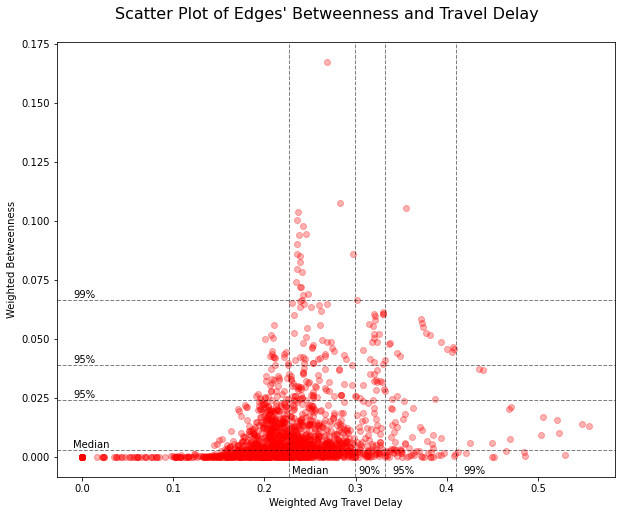

In [ ]:
w_delay = edge_bet_delay['weighted_delay']
w_bet = edge_bet_delay['weighted_bet']

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(w_delay, w_bet, marker='o', c='Red', alpha=0.3)

plt.axvline(0.227422, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(0.299787, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(0.332674, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(0.409929, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.text(0.230422, -.007, "Median")
plt.text(0.302787, -.007, "90%")
plt.text(0.340674, -.007, "95%")
plt.text(.417929, -.007, "99%")

plt.axhline(0.003147, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.024060, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.038964, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.066520, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.text(-.01, 0.004147, "Median")
plt.text(-.01, 0.025060, "95%")
plt.text(-.01, 0.039964, "95%")
plt.text(-.01, 0.067520, "99%")

plt.xlabel('Weighted Avg Travel Delay')
plt.ylabel('Weighted Betweenness')
plt.figtext(.5,0.92,"Scatter Plot of Edges' Betweenness and Travel Delay", fontsize=16, ha='center')

plt.show()

### K-means Clustering

In [ ]:
# normalize weighted betweenness and travel delay
edge_bet_delay['weighted_bet_norm'] = (edge_bet_delay['weighted_bet'] - min(edge_bet_delay['weighted_bet'])) / (max(edge_bet_delay['weighted_bet']) - min(edge_bet_delay['weighted_bet']))
edge_bet_delay['weighted_delay_norm'] = (edge_bet_delay['weighted_delay'] - min(edge_bet_delay['weighted_delay'])) / (max(edge_bet_delay['weighted_delay']) - min(edge_bet_delay['weighted_delay']))
edge_bet_delay

In [ ]:
edge_clustering = edge_bet_delay[['weighted_bet_norm', 'weighted_delay_norm']]
# parameters setting
kclusters = 10
kmeans = KMeans(n_clusters = kclusters, random_state=0)
kmeans.fit(edge_clustering)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
# result of clustering
edge_clustering.insert(0, 'Cluster1', kmeans.labels_)
edge_clustering = pd.concat([edge_bet_delay['edge'], edge_clustering], axis=1)
edge_clustering

,edge,Cluster1,weighted_bet_norm,weighted_delay_norm
0,中山區下埤里-中山區行仁里,7,0.120805,0.307154
1,中山區行仁里-中山區行政里,4,0.195738,0.387622
2,中山區行政里-中山區松江里,7,0.127933,0.400975
3,中山區松江里-中山區中央里,2,0.386889,0.436842
4,中山區中央里-中山區中吉里,1,0.052547,0.420309
...,...,...,...,...
2065,萬華區全德里-萬華區忠德里,0,0.000017,0.092663
2066,萬華區忠貞里-萬華區新和里,6,0.000067,0.328186
2067,萬華區日善里-萬華區和德里,1,0.000011,0.404080
2068,萬華區柳鄉里-北投區關渡里,6,0.000010,0.321798


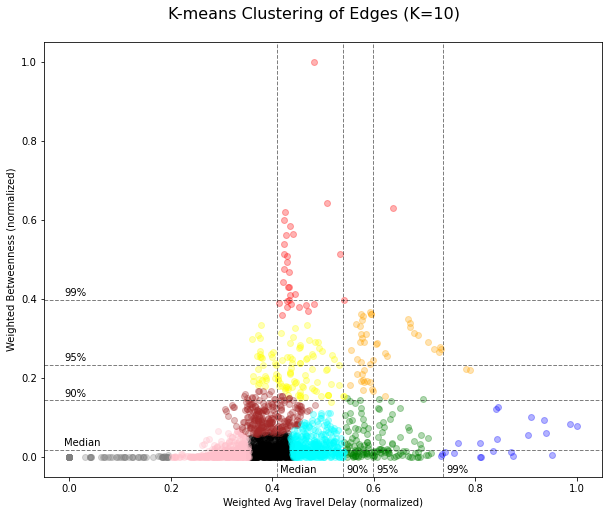

In [ ]:
# show clustering results on sctter plot
fig, ax = plt.subplots(figsize=(10,8))
color = ['Gray', 'Black', 'Red', 'Green', 'Yellow', 'Blue', 'Pink', 'Brown', 'Orange', 'Cyan']
for i in range(10):
  w_delay = edge_clustering[edge_clustering['Cluster1'] == i]['weighted_delay_norm']
  w_bet = edge_clustering[edge_clustering['Cluster1'] == i]['weighted_bet_norm']  
  ax.scatter(w_delay, w_bet, marker='o', c=color[i], alpha=0.3)

plt.axvline(0.408540, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(0.538537, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(0.597616, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axvline(0.736396, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.text(.415540, -.04, "Median")
plt.text(.545537, -.04, "90%")
plt.text(.604616, -.04, "95%")
plt.text(.743396, -.04, "99%")

plt.axhline(0.018790, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.143631, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.232606, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.axhline(0.397112, color = 'black', linestyle = 'dashed', linewidth = 1, alpha=0.5)
plt.text(-.01, 0.028790, "Median")
plt.text(-.01, 0.153631, "90%")
plt.text(-.01, 0.242606, "95%")
plt.text(-.01, 0.407112, "99%")

plt.xlabel('Weighted Avg Travel Delay (normalized)')
plt.ylabel('Weighted Betweenness (normalized)')
plt.figtext(.5,0.92,"K-means Clustering of Edges (K=10)", fontsize=16, ha='center')

plt.show()

### prepare for visualization on map

In [ ]:
# read pre-saved data for coordinates of villages
neigh_off_addr = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Taipei Transportation/neigh_off_addr.csv')
neigh_off_addr = neigh_off_addr[['dist_neigh', 'office_lat', 'office_lng']]
neigh_off_addr.loc[442, 'dist_neigh'] = '萬華區糖蔀里' # change the wrong character
neigh_off_addr
# for adding English name of villages
tp_df.iloc[239]['village'] = '糖蔀里'
tp_df['town_vill'] = tp_df['town'] + tp_df['village'] 
tp_df

In [ ]:
# capture villages in mandarin 
origin = []
destination = []
for i in range(len(edge_bet_delay)):
  origin.append(edge_bet_delay['edge'][i][0:6]) 
  destination.append(edge_bet_delay['edge'][i][7:13])
edge_bet_delay['origin'] = pd.Series(origin)
edge_bet_delay['destination'] = pd.Series(destination)
edge_bet_delay

In [ ]:
# add coordinates of origins and destinations 
edge_bet_delay['ori_lat'] = pd.Series([])
edge_bet_delay['ori_lng'] = pd.Series([])
edge_bet_delay['des_lat'] = pd.Series([])
edge_bet_delay['des_lng'] = pd.Series([])
edge_bet_delay['origin_eng'] = pd.Series([])
edge_bet_delay['destination_eng'] = pd.Series([])
for i in range(len(edge_bet_delay)):
  origin = edge_bet_delay['origin'][i]
  destination = edge_bet_delay['destination'][i]
  ori_lat = float(neigh_off_addr[neigh_off_addr['dist_neigh'] == origin]['office_lat'])
  ori_lng = float(neigh_off_addr[neigh_off_addr['dist_neigh'] == origin]['office_lng'])
  des_lat = float(neigh_off_addr[neigh_off_addr['dist_neigh'] == destination]['office_lat'])
  des_lng = float(neigh_off_addr[neigh_off_addr['dist_neigh'] == destination]['office_lng'])
  edge_bet_delay['ori_lat'][i] = ori_lat
  edge_bet_delay['ori_lng'][i] = ori_lng
  edge_bet_delay['des_lat'][i] = des_lat
  edge_bet_delay['des_lng'][i] = des_lng
  origin_eng = tp_df['village_eng'][tp_df['town_vill'] == origin].tolist()[0]
  destination_eng = tp_df['village_eng'][tp_df['town_vill'] == destination].tolist()[0]
  edge_bet_delay['origin_eng'][i] = origin_eng
  edge_bet_delay['destination_eng'][i] = destination_eng
# merge and clean up data
edge_bet_delay_cluster_df = pd.merge(edge_bet_delay, edge_clustering, on='edge')
edge_bet_delay_cluster_df = edge_bet_delay_cluster_df[['edge', 'weighted_bet', 'weighted_delay', 'origin_eng', 'destination_eng', 'ori_lat', 'ori_lng', 'des_lat', 'des_lng', 'Cluster1']]
edge_bet_delay_cluster_df.rename(columns={
    'edge': 'Edge', 
    'weighted_bet': 'Weighted Betweenness', 
    'weighted_delay': 'Weighted Travel Time Delay', 
    'origin_eng': 'Origin', 
    'destination_eng': 'Destination', 
    'Cluster1': 'Cluster'
}, inplace=True)
edge_bet_delay_cluster_df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Edge,Weighted Betweenness,Weighted Travel Time Delay,Origin,Destination,ori_lat,ori_lng,des_lat,des_lng,Cluster
0,中山區下埤里-中山區行仁里,0.020236,0.170983,Xiabi Vil.,Xingren Vil.,25.066653,121.541692,25.066129,121.539172,7
1,中山區行仁里-中山區行政里,0.032788,0.215778,Xingren Vil.,Xingzheng Vil.,25.066129,121.539172,25.063743,121.534406,4
2,中山區行政里-中山區松江里,0.021430,0.223210,Xingzheng Vil.,Songjiang Vil.,25.063743,121.534406,25.059446,121.534590,7
3,中山區松江里-中山區中央里,0.064808,0.243177,Songjiang Vil.,Zhongyang Vil.,25.059446,121.534590,25.054098,121.535346,2
4,中山區中央里-中山區中吉里,0.008802,0.233973,Zhongyang Vil.,Zhongji Vil.,25.054098,121.535346,25.057546,121.531019,1
...,...,...,...,...,...,...,...,...,...,...
2065,萬華區全德里-萬華區忠德里,0.000003,0.051583,Quande Vil.,Zhongde Vil.,25.025677,121.499852,25.024773,121.495437,0
2066,萬華區忠貞里-萬華區新和里,0.000011,0.182691,Zhongzhen Vil.,Xinhe Vil.,25.024922,121.502265,25.026971,121.504062,6
2067,萬華區日善里-萬華區和德里,0.000002,0.224939,Rishan Vil.,Hede Vil.,25.028241,121.500104,25.025314,121.491103,1
2068,萬華區柳鄉里-北投區關渡里,0.000002,0.179135,Liuxiang Vil.,Guandu Vil.,25.036932,121.494264,25.118642,121.468816,6


In [ ]:
# add percentile ranking 
edge_bet_delay_cluster_df['Weighted Betweenness (ranking)'] = edge_bet_delay_cluster_df['Weighted Betweenness'].rank(pct=True)
edge_bet_delay_cluster_df['Weighted Travel Time Delay (ranking)'] = edge_bet_delay_cluster_df['Weighted Travel Time Delay'].rank(pct=True)
edge_bet_delay_cluster_df['Weighted Betweenness (ranking)'] = pd.Series(["{0:.0f}%".format(val * 100) for val in edge_bet_delay_cluster_df['Weighted Betweenness (ranking)']], index = edge_bet_delay_cluster_df.index)
edge_bet_delay_cluster_df['Weighted Travel Time Delay (ranking)'] = pd.Series(["{0:.0f}%".format(val * 100) for val in edge_bet_delay_cluster_df['Weighted Travel Time Delay (ranking)']], index = edge_bet_delay_cluster_df.index)

edge_bet_delay_cluster_df

,Edge,Weighted Betweenness,Weighted Travel Time Delay,Origin,Destination,ori_lat,ori_lng,des_lat,des_lng,Cluster,Weighted Betweenness (ranking),Weighted Travel Time Delay (ranking)
0,中山區下埤里-中山區行仁里,0.020236,0.170983,Xiabi Vil.,Xingren Vil.,25.066653,121.541692,25.066129,121.539172,7,88%,10%
1,中山區行仁里-中山區行政里,0.032788,0.215778,Xingren Vil.,Xingzheng Vil.,25.066129,121.539172,25.063743,121.534406,4,94%,40%
2,中山區行政里-中山區松江里,0.021430,0.223210,Xingzheng Vil.,Songjiang Vil.,25.063743,121.534406,25.059446,121.534590,7,89%,46%
3,中山區松江里-中山區中央里,0.064808,0.243177,Songjiang Vil.,Zhongyang Vil.,25.059446,121.534590,25.054098,121.535346,2,99%,66%
4,中山區中央里-中山區中吉里,0.008802,0.233973,Zhongyang Vil.,Zhongji Vil.,25.054098,121.535346,25.057546,121.531019,1,72%,56%
...,...,...,...,...,...,...,...,...,...,...,...,...
2065,萬華區全德里-萬華區忠德里,0.000003,0.051583,Quande Vil.,Zhongde Vil.,25.025677,121.499852,25.024773,121.495437,0,2%,2%
2066,萬華區忠貞里-萬華區新和里,0.000011,0.182691,Zhongzhen Vil.,Xinhe Vil.,25.024922,121.502265,25.026971,121.504062,6,4%,14%
2067,萬華區日善里-萬華區和德里,0.000002,0.224939,Rishan Vil.,Hede Vil.,25.028241,121.500104,25.025314,121.491103,1,1%,48%
2068,萬華區柳鄉里-北投區關渡里,0.000002,0.179135,Liuxiang Vil.,Guandu Vil.,25.036932,121.494264,25.118642,121.468816,6,1%,13%
